# Spectral difference method 2D

### Using Cupy to enable GPU acceleration

In [1]:
%pylab inline
import cupy as cp
import polynomials as poly
from timeit import default_timer as timer
rcParams.update({'font.size': 15})
rcParams.update({'figure.figsize': (8,6)})

Populating the interactive namespace from numpy and matplotlib


In [2]:
for i in range(cp.cuda.runtime.getDeviceCount()):
    cp.cuda.runtime.setDevice(i)
    free,total=cp.cuda.runtime.memGetInfo()
    print(f"Device {i}: {round(free/1E9,0)}GB/{round(total/1E9,0)}GB" )

Device 0: 34.0GB/34.0GB
Device 1: 34.0GB/34.0GB


In [3]:
from enum import Enum

class CupyLocation(Enum):
    device = 0
    host = 1


class GPUData:
    def __init__(self, instance, value):
        self.values = {}
        self._set(instance, value)
    def __get__(self, instance, owner):
        if instance is None:
            return self
        icl = instance.current_location
        if icl != self.current_location:
            self.values[icl] = instance.convert_value(self.values[self.current_location])
            self.current_location = icl
        return self.values[icl]
    def __set__(self, instance, value):
        self._set(instance, value)
    def _set(self, instance, value):
        self.values[instance.current_location] = instance.convert_value(value)
        self.current_location = instance.current_location


def GPUDataManager(use_gpu: bool):
    class GPUDM:
        def __init__(self, use_gpu: bool):
            super().__setattr__("use_gpu", use_gpu)
            super().__setattr__("current_location", CupyLocation.host)
        def convert_value(self, value):
            if isinstance(value, np.ndarray) and self.current_location == CupyLocation.device:
                return cp.asarray(value)
            elif isinstance(value, cp.ndarray) and self.current_location == CupyLocation.host:
                return cp.asnumpy(value)
            return value
        def switch_to(self, location: CupyLocation):
            if not self.use_gpu:
                return
            self.current_location = location
        def __setattr__(self, key, value):
            if hasattr(self, key):
                super().__setattr__(key, value)
            else:
                setattr(type(self), key, GPUData(self, value))
        @property
        def xp(self):
            return {CupyLocation.host: np, CupyLocation.device: cp}[self.current_location]
    return GPUDM(use_gpu)

In [4]:
def solve_riemann(
    xp,
    U_L: np.ndarray,
    U_R: np.ndarray,
    vel: np.ndarray,
    roll_axis: int,
    *args,
    **kwargs,
) -> None:
    U_R[...] = xp.where(
        vel > 0,
        xp.roll(U_L, 1, axis=roll_axis),
        U_R,
    )
    U_L[...] = xp.roll(U_R, -1, axis=roll_axis)

In [5]:
class SD_Simulator:
    def __init__(
        self,
        init_fct = None,
        n: int = 8,
        Nx: int = 32,
        Ny: int = 32,
        riemann_solver_fct = solve_riemann,
        cfl_coeff: float = 0.8,
        dimension: int = 2,
        use_cupy: bool = True,
    ):
        self.n = n
        self.Nx = Nx
        self.Ny = Ny
        self.riemann_solver_fct = riemann_solver_fct
        self.init_fct = init_fct
        self.dimension = dimension
        self.cfl_coeff = cfl_coeff
        self.dm = GPUDataManager(use_cupy)
        
        self.dx = 1.0/self.Nx
        self.dy = 1.0/self.Ny
        self.time = 0
        self.n_step = 0
       
        self.x_fp = poly.flux_points(0.0, 1.0, n)
        self.x_sp = poly.solution_points(0.0, 1.0, n)
        na=np.newaxis
        self.mesh_cv = np.ndarray((2, Ny, Nx, n+2, n+2))
        self.mesh_cv[0] = (np.arange(Nx)[na, :, na, na] + self.x_fp[na, na, na, :])/Nx
        self.mesh_cv[1] = (np.arange(Ny)[:, na, na, na] + self.x_fp[na, na, :, na])/Ny

        self.x_faces, self.x_centers = self.faces_centers(Nx,self.x_fp)
        self.y_faces, self.y_centers = self.faces_centers(Ny,self.x_fp)
        
        self.x_flux = (np.tile(self.x_fp,Nx)+arange(Nx).repeat(n+2))/Nx
        
        # Values at flux pts from values at sol pts.
        self.dm.sp_to_fp = poly.lagrange_matrix(self.x_fp, self.x_sp)
        # Spatial derivative of the flux at sol pts from density at flux pts.
        self.dm.dfp_to_sp = poly.lagrangeprime_matrix(self.x_sp, self.x_fp)
        # Mean values in control volumes from values at sol pts.
        self.sp_to_cv = poly.intfromsol_matrix(self.x_sp, self.x_fp)
        self.cv_to_sp = np.linalg.inv(self.sp_to_cv)

        self.post_init()
        self.compute_dt()

    def post_init(self) -> None:
        self.U_init_cv = poly.quadrature_mean(self.mesh_cv, self.init_fct, 0)
        vx=poly.quadrature_mean(self.mesh_cv, self.init_fct, 1)
        self.dm.velocity_fp_x = np.einsum("fs,ijxs->ijxf", self.dm.sp_to_fp, vx)
        vy=poly.quadrature_mean(self.mesh_cv, self.init_fct, 2)
        self.dm.velocity_fp_y = np.einsum("fs,ijsx->ijfx", self.dm.sp_to_fp, vy)
        
        self.U_init_sp = self.compute_sp_from_cv(self.U_init_cv)

        # Final solution at the current time.
        self.dm.U_cv = self.U_init_cv.copy()
        self.dm.U_sp = self.U_init_sp.copy()

    def compute_sp_from_cv(self,U_cv) -> None:
        # Axes labels:
        #   i,j: cells
        #   k,l: sol pts
        #   m,n: control volumes
        return np.einsum("km,ln,ijmn->ijkl", self.cv_to_sp, self.cv_to_sp, U_cv)

    def compute_cv_from_sp(self,U_sp) -> None:
        # Axes labels:
        #   i,j: cells
        #   k,l: sol pts
        #   m,n: control volumes
        return np.einsum("mk,nl,ijkl->ijmn", self.sp_to_cv, self.sp_to_cv, U_sp)
        
    def compute_dt(self) -> None:
        v_max = np.max(self.dm.velocity_fp_x)+np.max(self.dm.velocity_fp_y)
        self.dt = self.cfl_coeff*self.dx/v_max/(self.n + 1)  
        return self.dt
    
    def faces_centers(self,N,x_fp):
        x_faces = 1/N*np.hstack((np.arange(N).repeat(self.n+1)+np.tile(x_fp[:-1],N),N))  
        x_centers = 0.5*(x_faces[1:]+x_faces[:-1])
        return x_faces,x_centers

In [6]:
def sine_wave(xy: np.ndarray,case: int) -> np.ndarray:
    if case==0:
        return 1.0+0.125*(np.sin(2*np.pi*(xy[0]+xy[1])))
    else:
        return np.ones(xy[0].shape)

def squash_dimensions(U: np.ndarray):
    return np.transpose(U, (0, 2, 1, 3)).reshape(U.shape[0]*U.shape[2],U.shape[1]*U.shape[3])

def regular_mesh(s,U):
    #Interpolate to a regular mesh
    n=s.n
    x = np.arange(n+2)/(n+1)
    x = .5*(x[1:]+x[:-1])
    x_sp = poly.solution_points(0.0, 1.0, n)
    m = poly.lagrange_matrix(x, x_sp)
    U_r = np.einsum("mk,nl,ijkl->ijmn", m, m, U)
    return squash_dimensions(U_r)

def regular_map(s,U):
    U = regular_mesh(s,U)
    im=imshow(U,origin="lower",extent=[0,1,0,1])
    xlabel(r'$x$')
    ylabel(r'$y$')
    title(f'$p={s.n}, N={s.Nx}$ at $t={round(s.time,2)}$')
    return im



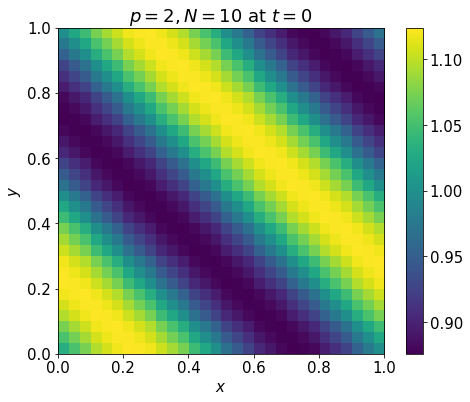

In [7]:
s = SD_Simulator(n=2,Nx=10,Ny=10,init_fct=sine_wave)
im=regular_map(s,s.dm.U_cv)
colorbar(im)

In [8]:
def initialize_ader(self):
    # ADER matrix.
    # (*)
    self.x_tp, self.w_tp = poly.gauss_legendre_quadrature(0.0, 1.0, self.n + 1)
    self.ader = poly.ader_matrix(self.x_tp, self.w_tp, 1.0)
    self.dm.invader = np.linalg.inv(self.ader)
    # Axes:
    #   0: ADER substeps
    #   2: cells
    #   3: pts inside cells
    self.dm.U_ader_sp = np.ndarray((self.n+1, self.Ny, self.Nx, self.n+1, self.n+1))
    # Solution at flux points
    self.dm.U_fp_x = np.ndarray((self.n+1, self.Ny, self.Nx, self.n+1, self.n+2))
    self.dm.U_fp_y = np.ndarray((self.n+1, self.Ny, self.Nx, self.n+2, self.n+1))

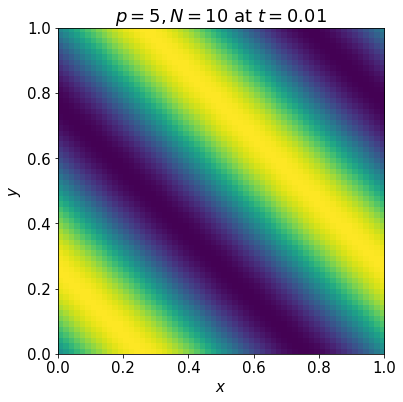

In [9]:
def perform_ader(self) -> None:
    self.n_step += 1
    na = np.newaxis
    xp=self.dm.xp
    # 1) Initialize U_ader_sp to u_sp, at all ADER time substeps.
    self.dm.U_ader_sp[...] = self.dm.U_sp[na]
    
    # 2) ADER scheme (Picard iteration).
    for ader_iter in range(self.n+1):
        # Map sol to flux points.
        # Axes labels:
        #   f: flux pts
        #   s: sol pts
        #   t: ADER substeps
        #   ij: elements

        self.dm.U_fp_x[...] = xp.einsum("fs,tijxs->tijxf", self.dm.sp_to_fp, self.dm.U_ader_sp)
        self.dm.U_fp_y[...] = xp.einsum("fs,tijsx->tijfx", self.dm.sp_to_fp, self.dm.U_ader_sp)
        # 2b) Solve Riemann problem at cell interfaces.
        #Let's solve for periodic boundaries
        # At interfaces between elements we have
        # u_L | u_R
        # u_L -> last value of each element
        # u_R -> first value of each elemet
        self.riemann_solver_fct(xp,
            self.dm.U_fp_x[...,:,-1],
            self.dm.U_fp_x[...,:,0],
            self.dm.velocity_fp_x[...,:,0],
            -2)
        self.riemann_solver_fct(xp,
            self.dm.U_fp_y[...,-1,:],
            self.dm.U_fp_y[...,0,:],
            self.dm.velocity_fp_y[...,0,:],
            -3)
        
        if ader_iter < self.n:
            # 2c) Compute new iteration value.
            # Axes labels:
            #   n: ADER substeps, next
            #   p: ADER substeps, prev
            #   s: sol pts
            #   f: flux pts
            #   ij: cells
            #Let's store dUdt first
            self.dm.U_ader_sp[...] = self.dm.U_sp[na] - xp.einsum(
                "np,p,pijkl->nijkl",
                self.dm.invader,
                self.w_tp,
                (xp.einsum(
                    "sf,pijxf->pijxs",
                    self.dm.dfp_to_sp,
                    self.dm.U_fp_x*self.dm.velocity_fp_x
                )/self.dx+
                 xp.einsum(
                    "sf,pijfx->pijsx",
                    self.dm.dfp_to_sp,
                    self.dm.U_fp_y*self.dm.velocity_fp_y
                 )/self.dy)
            )*self.dt
    # 3) ADER final update: weighted sum over ADER substeps.
    # Axes labels:
    #   t: ADER substeps
    #   s: sol pts
    #   f: flux pts
    #   ij: cells
    self.dm.U_sp -= np.einsum(
        "t,tijkl->ijkl",
        self.w_tp,
        (xp.einsum(
            "sf,pijxf->pijxs",
            self.dm.dfp_to_sp,
            self.dm.U_fp_x*self.dm.velocity_fp_x
        )/self.dx+
         xp.einsum(
            "sf,pijfx->pijsx",
            self.dm.dfp_to_sp,
            self.dm.U_fp_y*self.dm.velocity_fp_y
         )/self.dy)
    )*self.dt
    self.time = self.time + self.dt
    self.dm.U_cv[...] = self.compute_cv_from_sp(self.dm.U_sp)
      
s = SD_Simulator(n=5,Nx=10,Ny=10,init_fct=sine_wave)
initialize_ader(s)
perform_ader(s)
regular_map(s,s.dm.U_cv)

p=5, N=10: 76 time steps (Execution time: 2.276211 s)


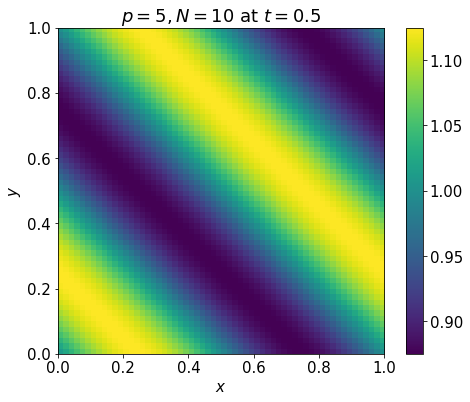

In [10]:
def perform_time_evolution(self, t_end: float) -> None:
    initialize_ader(s)
    self.dm.switch_to(CupyLocation.device)
    self.execution_time = -timer()
    while(self.time < t_end):
        #self.compute_dt()
        if(self.time + self.dt >= t_end):
            self.dt = t_end-self.time
        perform_ader(self)
    self.execution_time += timer() 
    print(f"p={self.n}, N={self.Nx}: {self.n_step} time steps (Execution time: {round(self.execution_time,6)} s)")
    self.dm.switch_to(CupyLocation.host)
    
s = SD_Simulator(n=5,Nx=10,Ny=10,init_fct=sine_wave)
perform_time_evolution(s,.5)
im=regular_map(s,s.dm.U_cv)
colorbar(im)

In [11]:
from collections import defaultdict

In [12]:
Ns = 2**arange(2,7)
sims=defaultdict(list)
for n in range(1,8):
    for N in Ns:
        s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=sine_wave)
        perform_time_evolution(s,1)
        sims[(n,N)] = s

p=1, N=4: 20 time steps (Execution time: 0.086846 s)
p=1, N=8: 40 time steps (Execution time: 0.169159 s)
p=1, N=16: 81 time steps (Execution time: 0.343159 s)
p=1, N=32: 161 time steps (Execution time: 0.681792 s)
p=1, N=64: 320 time steps (Execution time: 1.344038 s)
p=2, N=4: 31 time steps (Execution time: 0.191453 s)
p=2, N=8: 61 time steps (Execution time: 0.373866 s)
p=2, N=16: 121 time steps (Execution time: 0.739761 s)
p=2, N=32: 241 time steps (Execution time: 1.472359 s)
p=2, N=64: 481 time steps (Execution time: 2.914428 s)
p=3, N=4: 40 time steps (Execution time: 0.322206 s)
p=3, N=8: 81 time steps (Execution time: 0.644732 s)
p=3, N=16: 161 time steps (Execution time: 1.282251 s)
p=3, N=32: 320 time steps (Execution time: 2.54586 s)
p=3, N=64: 640 time steps (Execution time: 5.123745 s)
p=4, N=4: 50 time steps (Execution time: 0.504138 s)
p=4, N=8: 100 time steps (Execution time: 1.003353 s)
p=4, N=16: 200 time steps (Execution time: 2.00186 s)
p=4, N=32: 401 time steps (E

In [27]:
def compute_error(s):
    na=np.newaxis
    dx = (s.x_fp[1:]-s.x_fp[:-1])/s.Nx
    dy = (s.x_fp[1:]-s.x_fp[:-1])/s.Ny
    diff = np.abs(s.dm.U_cv-s.U_init_cv)
    diff *= dx[na,na,na,:]*dy[na,na,:,na] 
    diff=squash_dimensions(diff)
    return math.fsum((diff).ravel())

for n in range(1,8):
    errors=[]
    for N in Ns:
        errors.append(compute_error(sims[(n,N)]))
    loglog(Ns,errors,"-o",color=cm.viridis(n/7),label=f"p={n}")
    plot(Ns,errors[0]*(Ns[0]/Ns)**(n+1),"--", color="gray", lw=1)
ylabel(r"$\mathcal{L}_1$")
xlabel(r"$N$")
ylim(1E-14)
legend()   

AttributeError: 'list' object has no attribute 'x_fp'

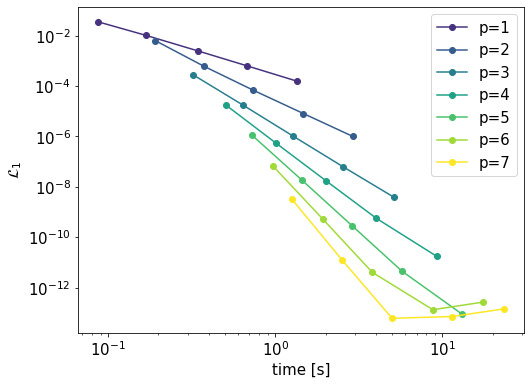

In [14]:
for n in range(1,8):
    errors=[]
    times=[]
    for N in Ns:
        errors.append(compute_error(sims[(n,N)]))
        times.append(sims[(n,N)].execution_time)
    loglog(times,errors,"-o",color=cm.viridis(n/7),label=f"p={n}")
ylabel(r"$\mathcal{L}_1$")
xlabel(r"time [s]")
legend()

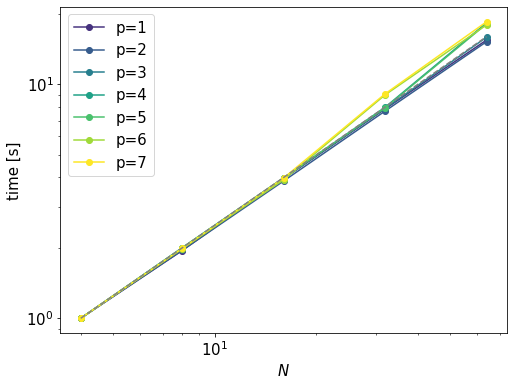

In [15]:
Ns=2**arange(2,7)
for n in range(1,8):
    times=[]
    for N in Ns:
        times.append(sims[(n,N)].execution_time)
    times=array(times)
    loglog(Ns,times/times[0],"-o",color=cm.viridis(n/7),label=f"p={n}")
plot(Ns,(Ns/Ns[0]),ls="--",color="gray")
ylabel(r"time [s]")
xlabel(r"$N$")
legend()

p=1, N=32: 1601 time steps (Execution time: 6.854146 s)
p=3, N=16: 1601 time steps (Execution time: 12.904158 s)
p=7, N=8: 1601 time steps (Execution time: 25.257895 s)


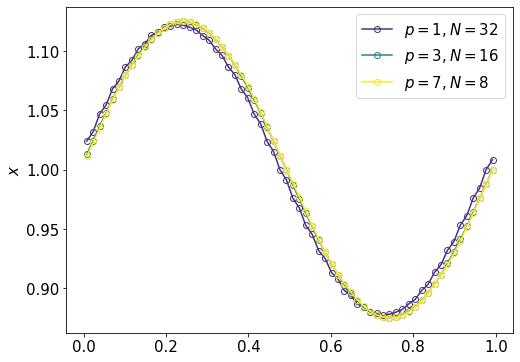

In [16]:
for n in [1,3,7]:
    N=64//(n+1)
    s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=sine_wave)
    perform_time_evolution(s,10)
    u = regular_mesh(s,s.dm.U_cv)
    x = linspace(0,1,s.Nx*(s.n+1)+1)
    x = .5*(x[1:]+x[:-1])
    plot(x,u[0],color=cm.viridis(n/7),label=f"$p={n}, N={N}$",marker="o",fillstyle="none")   
ylabel(r"$u$")
ylabel(r"$x$")
legend()

In [17]:
def step(xy: np.ndarray,ivar: int) -> np.ndarray:
    if ivar==0:
        return np.where(np.fabs(xy[0]-0.5)<0.25,np.where(np.fabs(xy[1]-0.5)<0.25,2,1),1)
    else:
        return np.ones(xy[0].shape)
    
s = SD_Simulator(n=2,Nx=20,Ny=20,init_fct=step)

p=2, N=20: 150 time steps (Execution time: 0.925437 s)


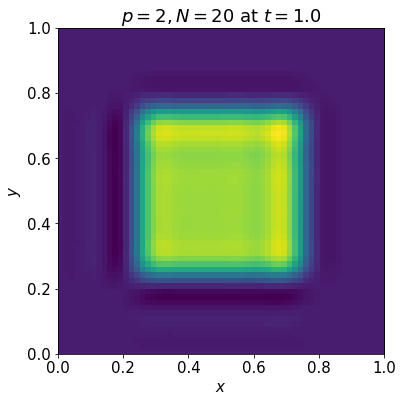

In [18]:
perform_time_evolution(s,1)
regular_map(s,s.dm.U_cv)

p=1, N=32: 161 time steps (Execution time: 0.688357 s)
p=3, N=16: 161 time steps (Execution time: 1.303826 s)
p=7, N=8: 161 time steps (Execution time: 2.531034 s)
p=15, N=4: 161 time steps (Execution time: 4.99981 s)
p=31, N=2: 161 time steps (Execution time: 11.629778 s)
p=63, N=1: 161 time steps (Execution time: 22.238923 s)


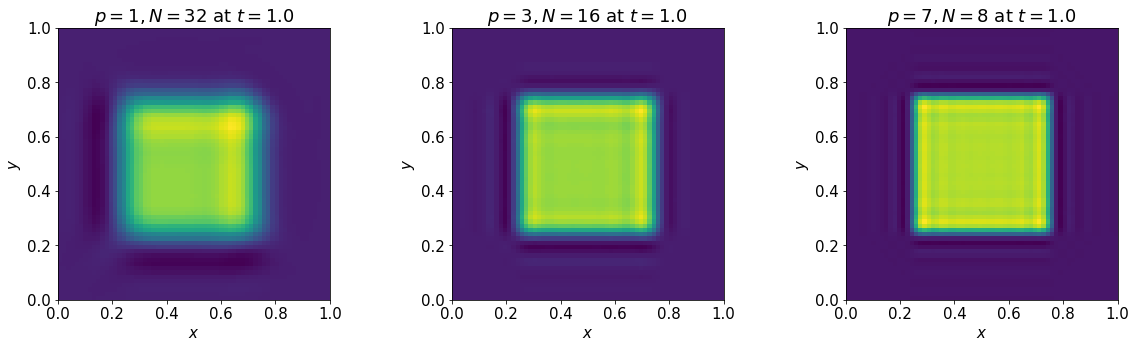

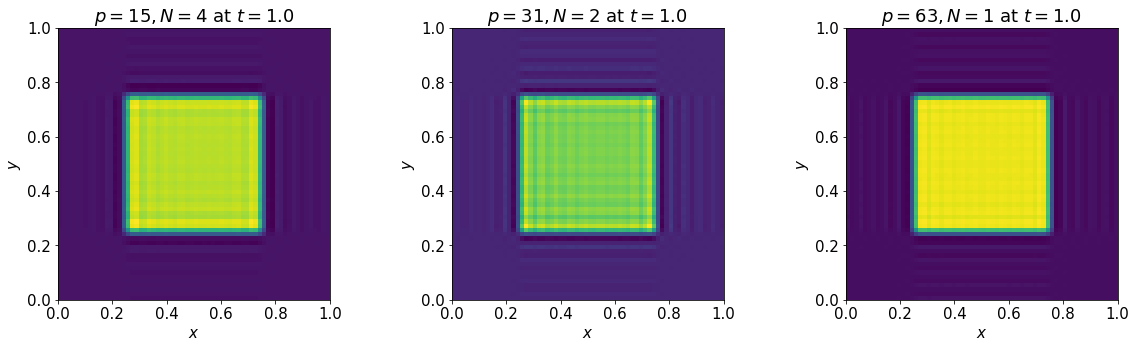

In [19]:
fig,axs = subplots(1,3,figsize=(20,5))
ns=[1,3,7]
N0=64
for i in range(3):
    n=ns[i]
    N=N0//(n+1)
    s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=step)
    perform_time_evolution(s,1)
    sca(axs[i])
    regular_map(s,s.dm.U_cv)
fig,axs = subplots(1,3,figsize=(20,5))
ns=[15,31,63]
for i in range(3):
    n=ns[i]
    N=N0//(n+1)
    s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=step)
    perform_time_evolution(s,1)
    sca(axs[i])
    regular_map(s,s.dm.U_cv)

In [20]:
def perform_iterations(self, steps: int) -> None:
    initialize_ader(s)
    self.dm.switch_to(CupyLocation.device)
    self.execution_time = -timer()
    for i in range(steps):
        perform_ader(self)
    self.execution_time += timer() 
    print(f"p={self.n}, N={self.Nx}: {self.n_step} time steps (Execution time: {round(self.execution_time,6)} s)")
    self.dm.switch_to(CupyLocation.host)

In [21]:
Ns=2**arange(4,11)
ns = array([1,3,7,15])

In [22]:
sims_gpu=defaultdict(list)
for n in ns:
    for N in Ns//(n+1):
        s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=sine_wave)
        perform_iterations(s,10)
        sims_gpu[(n,N)] = s

p=1, N=8: 10 time steps (Execution time: 0.04407 s)
p=1, N=16: 10 time steps (Execution time: 0.04348 s)
p=1, N=32: 10 time steps (Execution time: 0.043606 s)
p=1, N=64: 10 time steps (Execution time: 0.043707 s)
p=1, N=128: 10 time steps (Execution time: 0.046202 s)
p=1, N=256: 10 time steps (Execution time: 0.049696 s)
p=1, N=512: 10 time steps (Execution time: 0.076504 s)
p=3, N=4: 10 time steps (Execution time: 0.080922 s)
p=3, N=8: 10 time steps (Execution time: 0.08253 s)
p=3, N=16: 10 time steps (Execution time: 0.082569 s)
p=3, N=32: 10 time steps (Execution time: 0.081114 s)
p=3, N=64: 10 time steps (Execution time: 0.084921 s)
p=3, N=128: 10 time steps (Execution time: 0.098435 s)
p=3, N=256: 10 time steps (Execution time: 0.187725 s)
p=7, N=2: 10 time steps (Execution time: 0.167977 s)
p=7, N=4: 10 time steps (Execution time: 0.158671 s)
p=7, N=8: 10 time steps (Execution time: 0.15734 s)
p=7, N=16: 10 time steps (Execution time: 0.160444 s)
p=7, N=32: 10 time steps (Executi

In [23]:
sims_cpu=defaultdict(list)
for n in ns:
    for N in Ns//(n+1):
        s = SD_Simulator(n=n,Nx=N,Ny=N,init_fct=sine_wave,use_cupy=False)
        perform_iterations(s,10)
        sims_cpu[(n,N)] = s

p=1, N=8: 10 time steps (Execution time: 0.004561 s)
p=1, N=16: 10 time steps (Execution time: 0.010892 s)
p=1, N=32: 10 time steps (Execution time: 0.037266 s)
p=1, N=64: 10 time steps (Execution time: 0.144795 s)
p=1, N=128: 10 time steps (Execution time: 0.586621 s)
p=1, N=256: 10 time steps (Execution time: 2.419101 s)
p=1, N=512: 10 time steps (Execution time: 10.110324 s)
p=3, N=4: 10 time steps (Execution time: 0.009217 s)
p=3, N=8: 10 time steps (Execution time: 0.023436 s)
p=3, N=16: 10 time steps (Execution time: 0.08362 s)
p=3, N=32: 10 time steps (Execution time: 0.323916 s)
p=3, N=64: 10 time steps (Execution time: 1.306095 s)
p=3, N=128: 10 time steps (Execution time: 5.549385 s)
p=3, N=256: 10 time steps (Execution time: 24.211476 s)
p=7, N=2: 10 time steps (Execution time: 0.023264 s)
p=7, N=4: 10 time steps (Execution time: 0.064906 s)
p=7, N=8: 10 time steps (Execution time: 0.24853 s)
p=7, N=16: 10 time steps (Execution time: 0.965521 s)
p=7, N=32: 10 time steps (Exe

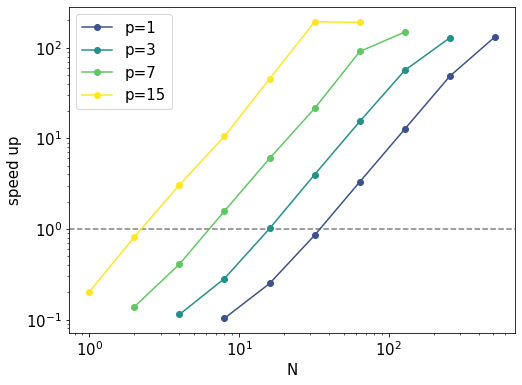

In [24]:
for n in ns:
    times_gpu=[]
    times_cpu=[]
    for N in Ns//(n+1):
        times_gpu.append(sims_gpu[(n,N)].execution_time)
        times_cpu.append(sims_cpu[(n,N)].execution_time)
    loglog(Ns//(n+1),array(times_cpu)/array(times_gpu),"-o",color=cm.viridis(log2(n+1)/4),label=f"p={n}")
axhline(1,ls="--",color="gray",zorder=0)
ylabel(r"speed up")
xlabel(r"N")
legend()

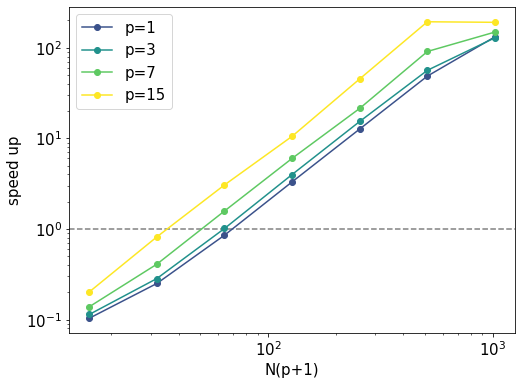

In [25]:
for n in ns:
    times_gpu=[]
    times_cpu=[] 
    for N in Ns//(n+1):
        times_gpu.append(sims_gpu[(n,N)].execution_time)
        times_cpu.append(sims_cpu[(n,N)].execution_time)
    loglog(Ns,array(times_cpu)/array(times_gpu),"-o",color=cm.viridis(log2(n+1)/4),label=f"p={n}")
axhline(1,ls="--",color="gray",zorder=0)
ylabel(r"speed up")
xlabel(r"N(p+1)")
legend()

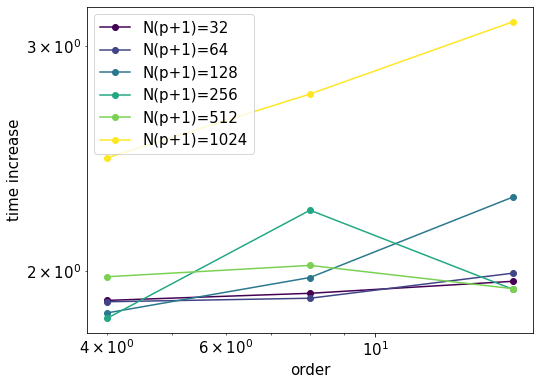

In [26]:
Ns=2**arange(5,11)
ns=array(ns)
for N in Ns:
    times=[]
    for n in ns:
        times.append(sims_gpu[(n,N//(n+1))].execution_time)
    times=array(times)
    loglog(ns[1:]+1,times[1:]/times[:-1],"-o",color=cm.viridis(log2(N/Ns[0])/5),label=f"N(p+1)={N}")
#yscale("log")
ylabel(r"time increase")
xlabel(r"order")
legend()